In [27]:
# import required packages
from imodels import get_clean_dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from imodels.tree.rf_plus.rf_plus.rf_plus_models import RandomForestPlusRegressor, RandomForestPlusClassifier
from imodels.tree.rf_plus.feature_importance.rfplus_explainer import  AloRFPlusMDI, RFPlusMDI
import shap
from subgroup_detection import *
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [10]:
# get pre-cleaned compas dataset from imodels
X, y, feature_names = get_clean_dataset(183, data_source='openml')
X = pd.DataFrame(X, columns=feature_names)

In [18]:
y = y.astype(float)

In [20]:
# split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=0.25,
                                                      random_state=2)

In [21]:
y

array([15.,  7.,  9., ...,  9., 10., 12.])

In [22]:
# fit RF model
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

# # check performance on test set
# y_pred = rf.predict(X_test)

# # compute accuracy on the test set
# accuracy = np.mean(y_pred == y_test)

# print(f'RF Test Set Accuracy: {accuracy}')


RandomForestRegressor(random_state=0)

In [6]:
# get feature importances
explainer = shap.TreeExplainer(rf)
shap_values = np.abs(explainer.shap_values(X_train, check_additivity=False))
shap_rankings = np.argsort(-shap_values, axis = 1)

In [7]:
# get rbo distance matrix
shap_rbo_train = compute_rbo_matrix(shap_rankings, form = 'distance')

In [8]:
shap_copy = pd.DataFrame(shap_values, columns=X_train.columns).copy()
shap_valid_values = np.abs(explainer.shap_values(X_valid,
                                                check_additivity=False))
shap_valid_rankings = np.argsort(-shap_valid_values, axis = 1)
lowest_misclassified = np.inf
opt_num_clusters = -1
acc_lst = []
time_since_king = 0
opt_clusters = None
for num_clusters in np.arange(2, 21):
    print("Now Calculating for", num_clusters, "Clusters")
    shap_train_clusters = assign_training_clusters(shap_rbo_train, num_clusters)
    valid_clusters = assign_testing_clusters(method="centroid",
                                            median_approx=True,
                                            rbo_distance_matrix=shap_rbo_train,
                                            lfi_train_ranking=shap_rankings,
                                            lfi_test_ranking=shap_valid_rankings,
                                            clusters = shap_train_clusters)
    cluster_trainX = []
    cluster_trainy = []
    cluster_validX = []
    cluster_validy = []
    total_misclassified = 0
    for cluster in np.arange(1, num_clusters + 1):
        local_rf = RandomForestRegressor(n_estimators=100, random_state=0)
        local_rf.fit(X_train[shap_train_clusters == cluster], y_train[shap_train_clusters == cluster])
        local_preds = local_rf.predict(X_valid[valid_clusters == cluster])
        local_misclassified = np.sum(local_preds != y_valid[valid_clusters == cluster])
        total_misclassified += local_misclassified
    if total_misclassified < lowest_misclassified:
        lowest_misclassified = total_misclassified
        opt_num_clusters = num_clusters
        time_since_king = 0
        opt_clusters = shap_train_clusters
    else:
        time_since_king += 1
    print("Number of Misclassified w/", num_clusters, "Clusters:", total_misclassified)
    print("Accuracy w/", num_clusters, "Clusters:", f"{100*(1 - (total_misclassified / len(y_valid))):.2f}%")
    acc_lst.append(100*(1 - (total_misclassified / len(y_valid))))
    if time_since_king > 2:
        break
print(f'Optimal Number of Clusters: {opt_num_clusters}')
print(f'Lowest Number of Misclassified: {lowest_misclassified}')
print(f'Accuracy: {1 - lowest_misclassified / len(y_valid)}')

Now Calculating for 2 Clusters
Number of Misclassified w/ 2 Clusters: 78
Accuracy w/ 2 Clusters: 0.00%
Now Calculating for 3 Clusters
Number of Misclassified w/ 3 Clusters: 78
Accuracy w/ 3 Clusters: 0.00%
Now Calculating for 4 Clusters
Number of Misclassified w/ 4 Clusters: 78
Accuracy w/ 4 Clusters: 0.00%
Now Calculating for 5 Clusters
Number of Misclassified w/ 5 Clusters: 78
Accuracy w/ 5 Clusters: 0.00%
Optimal Number of Clusters: 2
Lowest Number of Misclassified: 78
Accuracy: 0.0


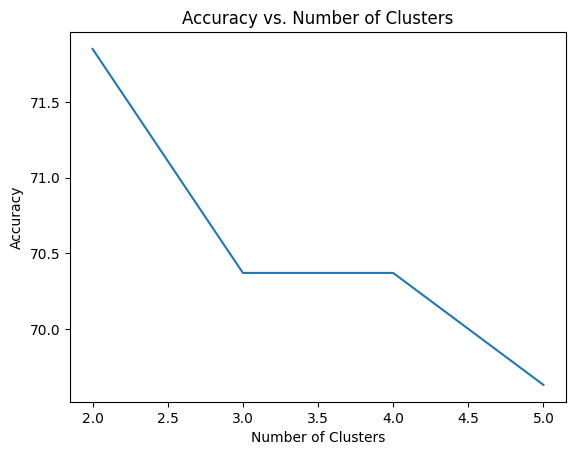

In [81]:
# plot elbow plot of accuracy
plt.plot(np.arange(2, len(acc_lst)+2), acc_lst)
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Clusters')
plt.show()

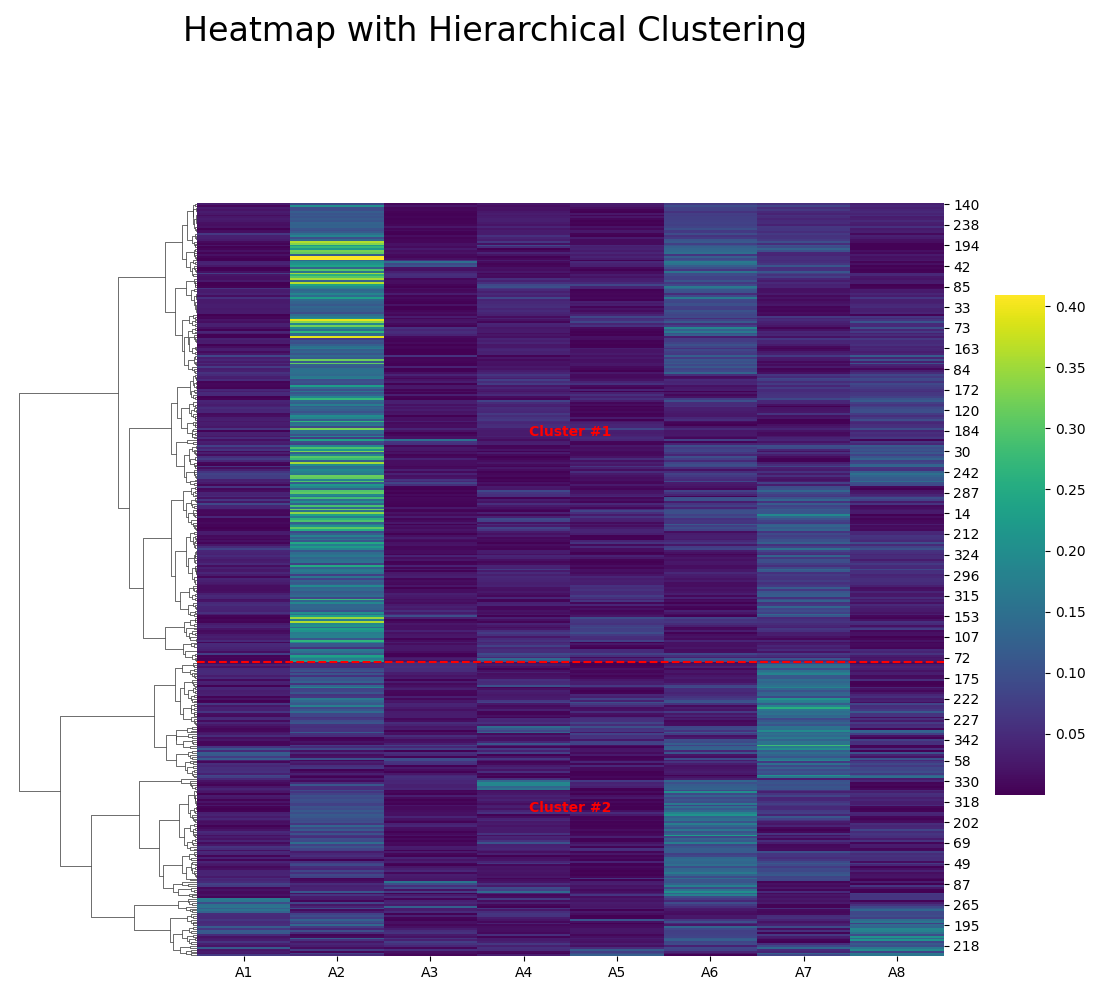

In [82]:
plot_training_clusters(shap_copy, shap_rbo_train, opt_clusters)

In [23]:
# fit rf+
rf_plus = RandomForestPlusRegressor(rf, prediction_model=RidgeCV())
rf_plus.fit(X_train, y_train)

# check performance on test set
# y_pred_rf_plus = rf_plus.predict(X_test)
# y_pred_proba_rf_plus = rf_plus.predict_proba(X_test)[:, 1]

# compute accuracy on the test set
# accuracy_rf_plus = np.mean(y_pred_rf_plus == y_test)
# misclassified_rf_plus = np.sum(y_pred_rf_plus != y_test)
# auroc_rf_plus = roc_auc_score(y_test, y_pred_proba_rf_plus)
# auprc_rf_plus = average_precision_score(y_test, y_pred_proba_rf_plus)
# f1_rf_plus = f1_score(y_test, y_pred_rf_plus)

# print(f'RF+ Test Set Accuracy: {accuracy_rf_plus}')
# print(f'RF+ Test Set # Misclassified: {misclassified_rf_plus}')
# print(f'RF+ Test Set AUROC: {auroc_rf_plus}')
# print(f'RF+ Test Set AUPRC: {auprc_rf_plus}')
# print(f'RF+ Test Set F1: {f1_rf_plus}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.4s finished


In [29]:
# get feature importances
mdi_explainer = RFPlusMDI(rf_plus, evaluate_on='oob')
mdi, _ = mdi_explainer.explain(np.asarray(X_train), y_train)
mdi_rankings = mdi_explainer.get_rankings(mdi)

In [27]:
# get rbo distance matrix
mdi_rbo_train = compute_rbo_matrix(mdi_rankings, form = 'distance')

In [28]:
mdi_copy = pd.DataFrame(mdi, columns=X_train.columns).copy()
mdi_train_clusters = assign_training_clusters(mdi_rbo_train, opt_num_clusters)

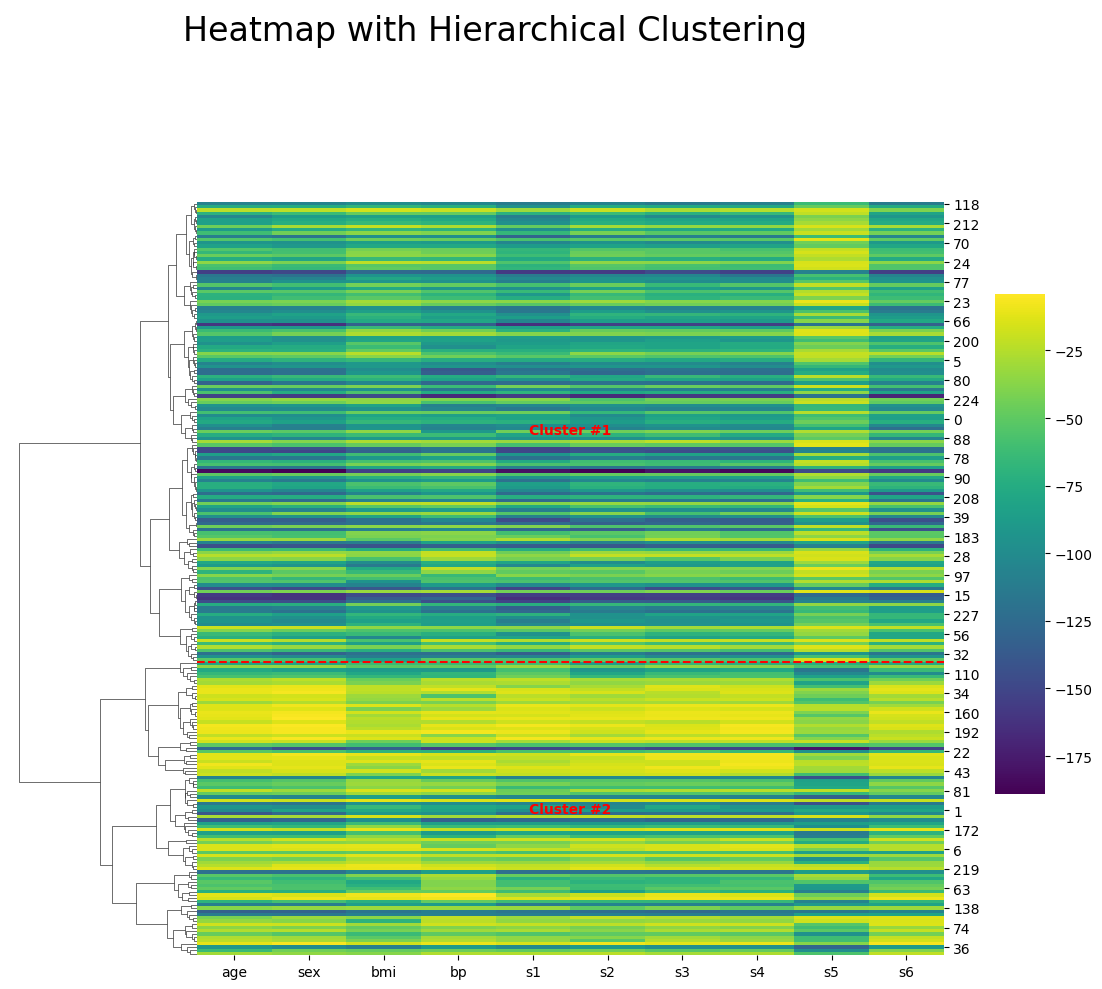

In [29]:
plot_training_clusters(mdi_copy, mdi_rbo_train, mdi_train_clusters)

In [30]:
# get feature importances
mdi_explainer = AloRFPlusMDI(rf_plus, evaluate_on='oob')
mdi = np.abs(mdi_explainer.explain_subtract_intercept(np.asarray(X_train), y_train, leaf_average=True))
mdi_rankings = mdi_explainer.get_rankings(mdi)

In [31]:
# get rbo distance matrix
mdi_rbo_train = compute_rbo_matrix(mdi_rankings, form = 'distance')

In [32]:
mdi_copy = pd.DataFrame(mdi, columns=X_train.columns).copy()
mdi_train_clusters = assign_training_clusters(mdi_rbo_train, opt_num_clusters)

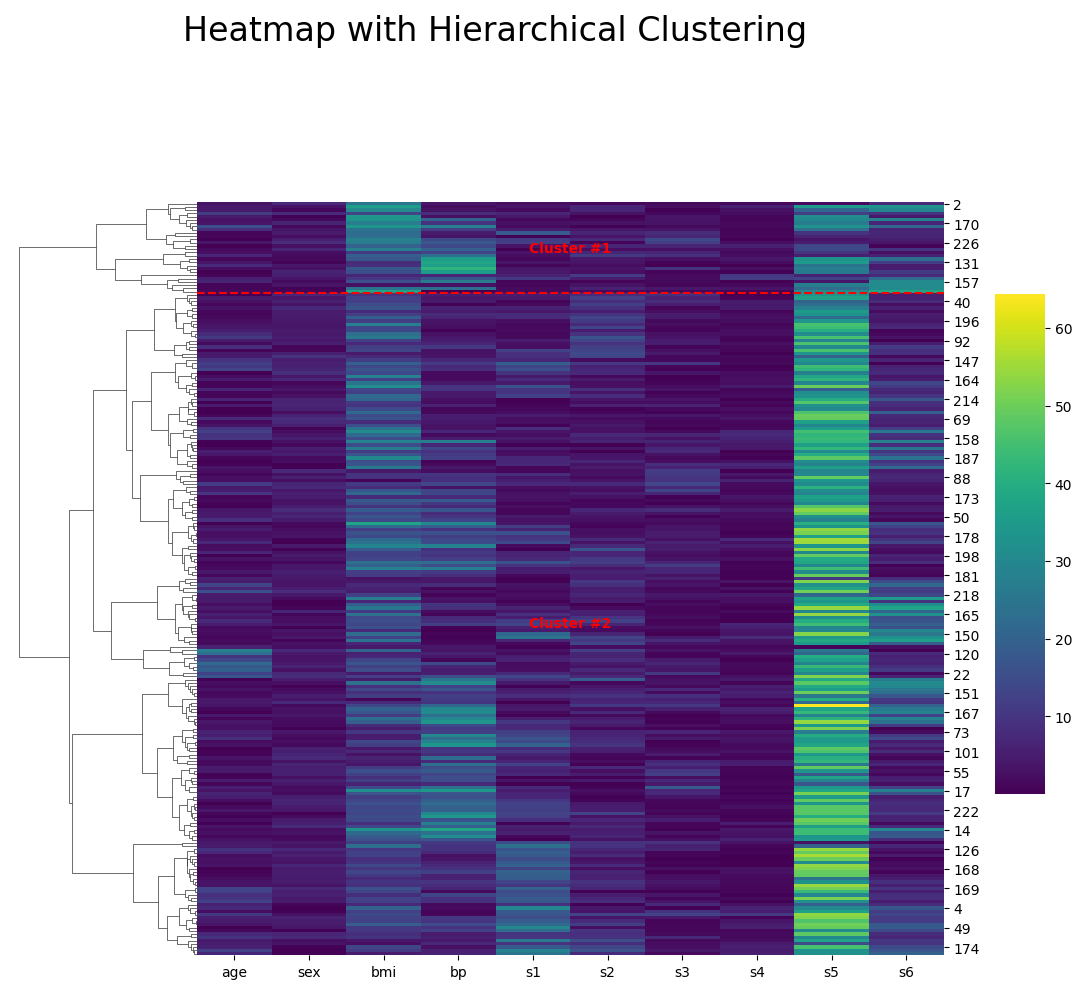

In [33]:
plot_training_clusters(mdi_copy, mdi_rbo_train, mdi_train_clusters)

In [87]:
# get mdi rankings assignments for test points
mdi_test, _ = mdi_explainer.explain(np.asarray(X_test), leaf_average=True)
mdi_test_rankings = mdi_explainer.get_rankings(mdi_test)

In [88]:
mdi_test_clusters = assign_testing_clusters(method = "centroid", median_approx = False,
                                     rbo_distance_matrix = mdi_rbo_train,
                                     lfi_train_ranking = mdi_rankings,
                                     lfi_test_ranking = mdi_test_rankings,
                                     clusters = mdi_train_clusters)

In [89]:
cluster_trainX = []
cluster_trainy = []
cluster_testX = []
cluster_testy = []
total_misclassified = 0
for cluster in np.arange(1, opt_num_clusters + 1):
    local_rf_plus = RandomForestPlusRegressor(RandomForestRegressor(n_estimators=100, random_state=0))
    local_rf_plus.fit(X_train[mdi_train_clusters == cluster], y_train[mdi_train_clusters == cluster])
    local_preds = local_rf_plus.predict(X_test[mdi_test_clusters == cluster])
    local_misclassified = np.sum(local_preds != y_test[mdi_test_clusters == cluster])
    total_misclassified += local_misclassified
1-(total_misclassified / len(y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/errors.py:66: RuntimeWarning: Model did not converge for smaller values of lambda, returning solution for the largest 95 values.
  warnings.warn("Model did not converge for smaller values of lambda, "
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/errors.py:66: RuntimeWarning: Model did not converge for smaller values of lambda, returning solution for the largest 95 values.
  warnings.warn("Model did not converge for smaller values of lambda, "
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.7s finished


0.7272727272727273

In [90]:
shap_copy = pd.DataFrame(shap_values, columns=X_train.columns).copy()
shap_train_clusters = assign_training_clusters(shap_rbo_train, opt_num_clusters)

In [91]:
shap_copy = pd.DataFrame(shap_values, columns=X_train.columns).copy()
shap_train_clusters = assign_training_clusters(shap_rbo_train, opt_num_clusters)
shap_test_values = np.abs(explainer.shap_values(X_test,
                                                check_additivity=False))[:,:,0]
shap_test_rankings = np.argsort(-shap_test_values, axis = 1)
shap_test_clusters = assign_testing_clusters(method="centroid", median_approx=False,
                                        rbo_distance_matrix=shap_rbo_train,
                                        lfi_train_ranking=shap_rankings,
                                        lfi_test_ranking=shap_test_rankings,
                                        clusters = shap_train_clusters)

In [92]:
cluster_trainX = []
cluster_trainy = []
cluster_testX = []
cluster_testy = []
total_misclassified = 0
for cluster in np.arange(1, opt_num_clusters + 1):
    local_rf = RandomForestRegressor(n_estimators=100, random_state=0)
    local_rf.fit(X_train[shap_train_clusters == cluster], y_train[shap_train_clusters == cluster])
    local_preds = local_rf.predict(X_test[shap_test_clusters == cluster])
    local_misclassified = np.sum(local_preds != y_test[shap_test_clusters == cluster])
    total_misclassified += local_misclassified
1-(total_misclassified / len(y_test))

0.7186147186147186

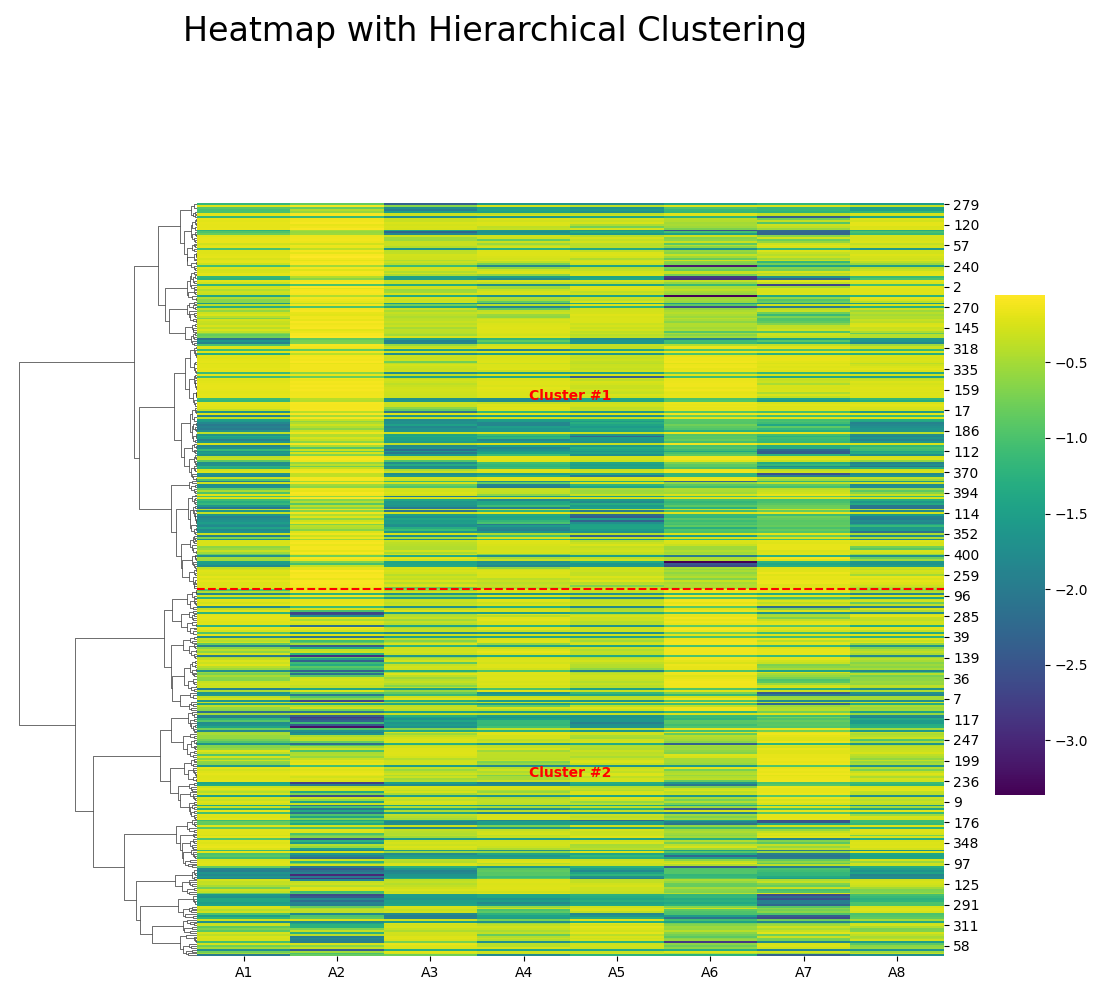

In [93]:
plot_training_clusters(mdi_copy, mdi_rbo_train, mdi_train_clusters)

In [94]:
# # get training error of rf+
# y_pred_rf_plus_train = rf_plus.predict(X_train)
# y_pred_proba_rf_plus_train = rf_plus.predict_proba(X_train)[:, 1]

# # compute accuracy on the train set
# accuracy_rf_plus_train = np.mean(y_pred_rf_plus_train == y_train)
# misclassified_rf_plus_train = np.sum(y_pred_rf_plus_train != y_train)
# auroc_rf_plus_train = roc_auc_score(y_train, y_pred_proba_rf_plus_train)
# auprc_rf_plus_train = average_precision_score(y_train, y_pred_proba_rf_plus_train)
# f1_rf_plus_train = f1_score(y_train, y_pred_rf_plus_train)

# print(f'RF+ Train Set Accuracy: {accuracy_rf_plus_train}')
# print(f'RF+ Train Set # Misclassified: {misclassified_rf_plus_train}')
# print(f'RF+ Train Set AUROC: {auroc_rf_plus_train}')
# print(f'RF+ Train Set AUPRC: {auprc_rf_plus_train}')
# print(f'RF+ Train Set F1: {f1_rf_plus_train}')


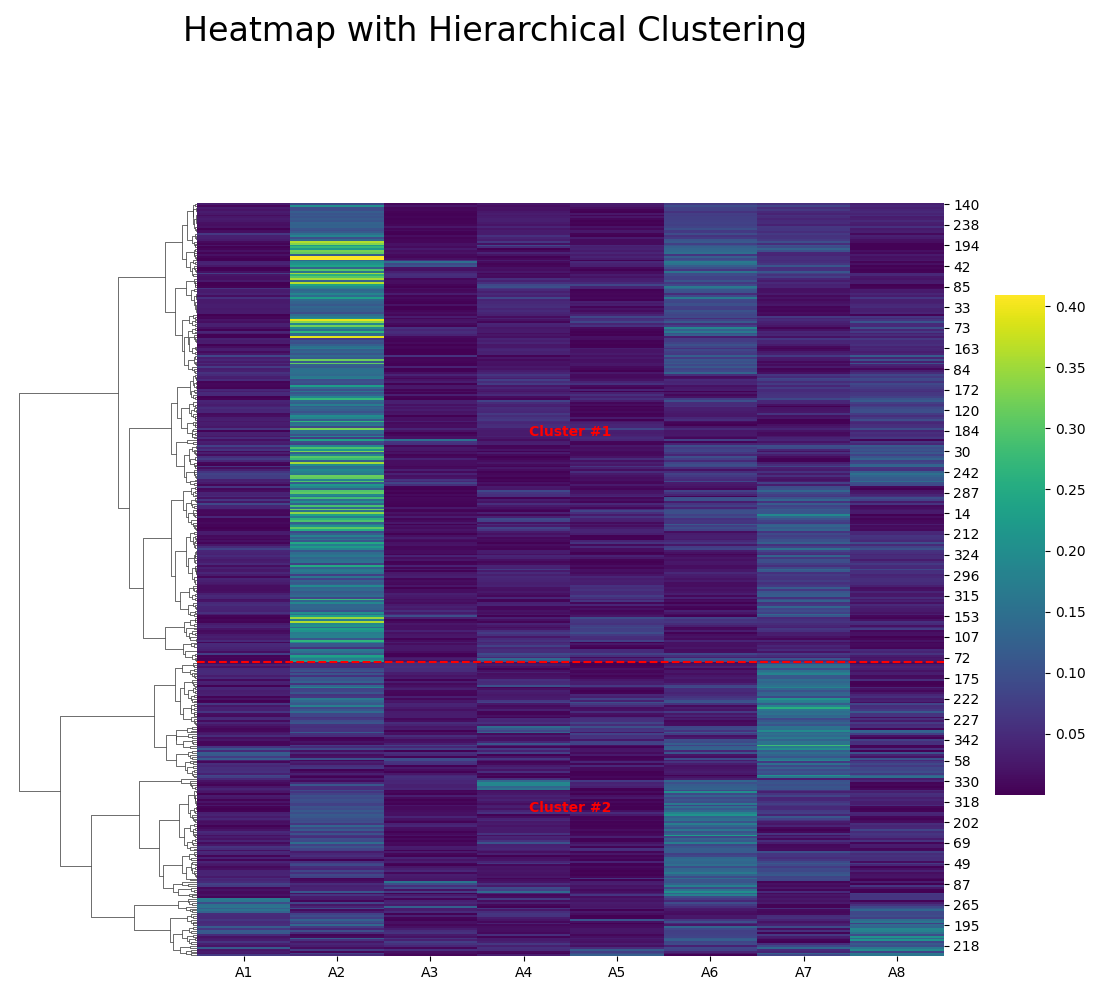

In [95]:
plot_training_clusters(shap_copy, shap_rbo_train, shap_train_clusters)

In [96]:
shap_cluster_idxs = match_subgroups(mdi_train_clusters, shap_train_clusters)

dict1to2
{1: 1, 2: 2}
dict2to1
{1: 1, 2: 2}


In [97]:
np.sum(mdi_train_clusters == shap_cluster_idxs)/len(mdi_train_clusters)

0.8383084577114428